In [1]:
from IPython.display import display
from tqdm import trange
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import numpy as np
import torch
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import Dataset

/Users/tchuang/.local/share/virtualenvs/OpenCVDL2023HW2-jWty1gEm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
check_point1 = "/Users/tchuang/GitHub/OpenCVDL2023HW2/src/model/without/detr-resnet-50_2023-12-24_13:45:39_best1"
check_point2 = "/Users/tchuang/GitHub/OpenCVDL2023HW2/src/model/with/detr-resnet-50_2023-12-24_13:45:46_best1"

# training_dataset_dir = "/Users/tchuang/GitHub/OpenCVDL2023HW2/data/raw/dataset/training_dataset"
validation_dataset_dir = "/Users/tchuang/GitHub/OpenCVDL2023HW2/data/raw/dataset/validation_dataset"
inference_dataset_dir = "/Users/tchuang/GitHub/OpenCVDL2023HW2/data/raw/dataset/inference_dataset"

In [3]:
class CatDogDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        
        cat_image_dir = os.path.join(dataset_dir, 'Cat', '*.jpg')
        cat_image_paths = glob.glob(cat_image_dir)
        print(f"cat_image_paths: {cat_image_dir}, len: {len(cat_image_paths)}")
        cat_image_labels = torch.zeros(size=(len(cat_image_paths),))
        
        dog_image_dir = os.path.join(dataset_dir, 'Dog', '*.jpg')
        dog_image_paths = glob.glob(dog_image_dir)
        print(f"dog_image_paths: {dog_image_dir}, len: {len(dog_image_paths)}")
        dog_image_labels = torch.ones(size=(len(dog_image_paths),))
        
        self.image_paths = np.concatenate((cat_image_paths, dog_image_paths))
        self.image_labels = np.concatenate(( cat_image_labels, dog_image_labels))

        self.transform = transform
        
         
    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = np.array(image)
            iamge = self.transform(image)
            image = Image.fromarray(image)
            
        label = self.image_labels[idx]
        label = torch.from_numpy(np.array([[label]]))
        return {'image': image,
                 'label': label}
    
    def label_dict(self):
        return {0:'Cat', 1:'Dog'}
    
    def get_cat_dog_image(self):
        cat_image = read_image(self.image_paths[0])
        dog_image = read_image(self.image_paths[-1])
        return cat_image, dog_image

train_transforms = v2.Compose(
    [
        v2.ToDtype(torch.float32),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        v2.Resize(size=(224, 224)),
    ]
)

# train_dataset = CatDogDataset(training_dataset_dir, transform=None)
validation_dataset = CatDogDataset(validation_dataset_dir, transform=None)
inference_dataset = CatDogDataset(inference_dataset_dir, transform=None)

cat_image_paths: /Users/tchuang/GitHub/OpenCVDL2023HW2/data/raw/dataset/validation_dataset/Cat/*.jpg, len: 588
dog_image_paths: /Users/tchuang/GitHub/OpenCVDL2023HW2/data/raw/dataset/validation_dataset/Dog/*.jpg, len: 1212
cat_image_paths: /Users/tchuang/GitHub/OpenCVDL2023HW2/data/raw/dataset/inference_dataset/Cat/*.jpg, len: 5
dog_image_paths: /Users/tchuang/GitHub/OpenCVDL2023HW2/data/raw/dataset/inference_dataset/Dog/*.jpg, len: 5


In [4]:
from transformers import ConvNextImageProcessor, ResNetForImageClassification
image_processor = ConvNextImageProcessor.from_pretrained("microsoft/resnet-50")

model = ResNetForImageClassification.from_pretrained(
    check_point1,
    ignore_mismatched_sizes=True,
)
model.classifier.add_module("2", torch.nn.Sigmoid())

correct = 0
for i in trange(len(validation_dataset)):
    image = validation_dataset[i]['image']
    label = validation_dataset[i]['label']
    inputs = image_processor(image, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    prediction = np.round(logits)
    if label == prediction:
        correct += 1
accuracy_without = correct/len(validation_dataset)
print(f"Without Random-Erasing correct: {correct}, total: {len(validation_dataset)}, accuracy: {accuracy_without}")

model = ResNetForImageClassification.from_pretrained(
    check_point2,
    ignore_mismatched_sizes=True,
)
model.classifier.add_module("2", torch.nn.Sigmoid())

correct = 0
for i in trange(len(validation_dataset)):
    image = validation_dataset[i]['image']
    label = validation_dataset[i]['label']
    inputs = image_processor(image, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    prediction = np.round(logits)
    if label == prediction:
        correct += 1
accuracy_with = correct/len(validation_dataset)
print(f"With Random-Erasing correct: {correct}, total: {len(validation_dataset)}, accuracy: {accuracy_with}")

100%|██████████| 1800/1800 [04:48<00:00,  6.25it/s]


Without Random-Erasing correct: 1780, total: 1800, accuracy: 0.9888888888888889


100%|██████████| 1800/1800 [06:38<00:00,  4.52it/s]

With Random-Erasing correct: 1784, total: 1800, accuracy: 0.9911111111111112


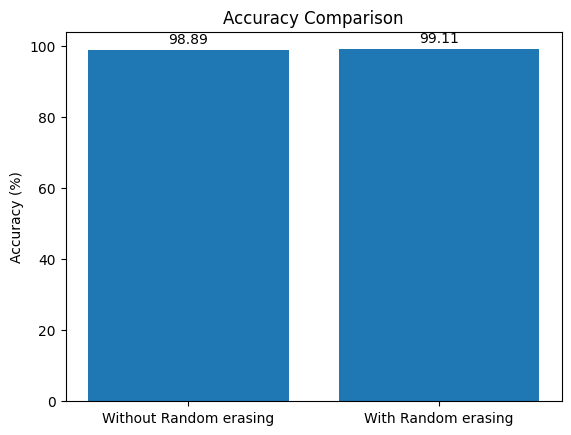

In [6]:
plt.bar(['Without Random erasing', 'With Random erasing'], [accuracy_without * 100, accuracy_with * 100])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy (%)')

for i, v in enumerate([accuracy_without * 100, accuracy_with * 100]):
    plt.text(i, v + 1, str(round(v, 2)), ha='center', va='bottom')

plt.show()